A closer look at LHS 2686, which is maybe variable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
from astropy.convolution import convolve, Box1DKernel

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/stsci/tools/nmpfit.py:10: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/stsci/tools/gfit.py:20: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


In [2]:
cspec = 'coadds/LHS-2686_g140m_coadd_v1.ecsv'
specs = glob.glob('coadds/LHS-2686_g140m_o*')
specs

['coadds/LHS-2686_g140m_odlm34030.ecsv',
 'coadds/LHS-2686_g140m_odlm34040.ecsv',
 'coadds/LHS-2686_g140m_odlm35030.ecsv',
 'coadds/LHS-2686_g140m_odlm35040.ecsv']

In [3]:
cdata = Table.read(cspec)
w, f, e = cdata['WAVELENGTH'], cdata['FLUX'], cdata['ERROR']
#plt.step(w, f, where='mid')
#plt.step(w, e, where='mid')
#plt.xlim(1212, 1218)

coadds/LHS-2686_g140m_odlm34030.ecsv
5.726477302620554e-14
1.4033480752901416e-15


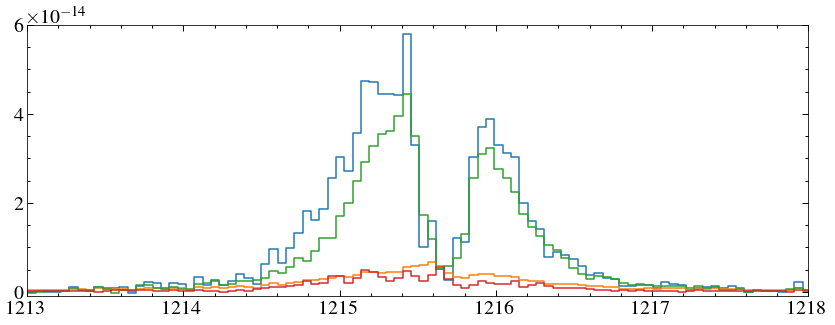

coadds/LHS-2686_g140m_odlm34040.ecsv
4.83390846378788e-14
1.4241390910971577e-15


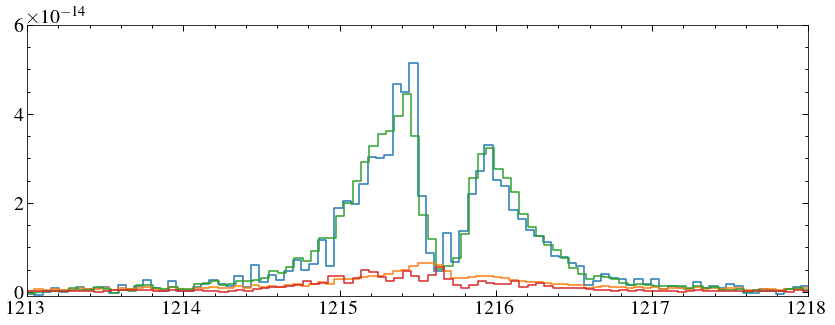

coadds/LHS-2686_g140m_odlm35030.ecsv
5.0599537006631476e-14
1.3829527657811447e-15


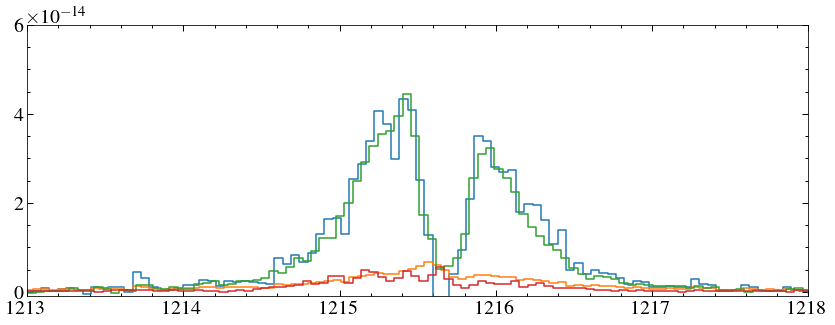

coadds/LHS-2686_g140m_odlm35040.ecsv
4.761390481535718e-14
1.4911818306177676e-15


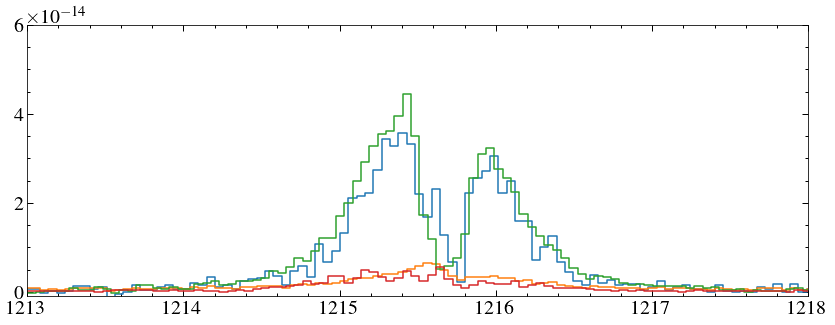

In [4]:
for sp in specs:
    data = Table.read(sp)
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    plt.step(wi, fi, where='mid')
    plt.step(wi, ei, where='mid')
    print(sp)
    print(np.trapz(fi, wi))
    print(np.sum(ei[1:]**2*np.diff(wi)**2)**0.5)
    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    plt.xlim(1213, 1218)
    plt.ylim(-0.1e-14, 6e-14)
    plt.show()

In [5]:
#checking the coadd saved correctly
"""x1ds= glob.glob('to_coadd/odlm3*')
specs, x1ds = np.array(specs)[np.argsort(specs)], np.array(x1ds)[np.argsort(x1ds)]
specs, x1ds
for sp, x in zip(specs, x1ds):
    data = Table.read(sp)
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    plt.step(wi, fi, where='mid')
    plt.step(wi, ei, where='mid')
    data = fits.getdata(x, 1)[0]
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    plt.step(wi, fi, where='mid')
    plt.step(wi, ei, where='mid')t
    plt.xlim(1213, 1218)
    plt.ylim(-0.1e-14, 6e-14)
    plt.show()"""

"x1ds= glob.glob('to_coadd/odlm3*')\nspecs, x1ds = np.array(specs)[np.argsort(specs)], np.array(x1ds)[np.argsort(x1ds)]\nspecs, x1ds\nfor sp, x in zip(specs, x1ds):\n    data = Table.read(sp)\n    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']\n    plt.step(wi, fi, where='mid')\n    plt.step(wi, ei, where='mid')\n    data = fits.getdata(x, 1)[0]\n    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']\n    plt.step(wi, fi, where='mid')\n    plt.step(wi, ei, where='mid')t\n    plt.xlim(1213, 1218)\n    plt.ylim(-0.1e-14, 6e-14)\n    plt.show()"

(1213, 1217)

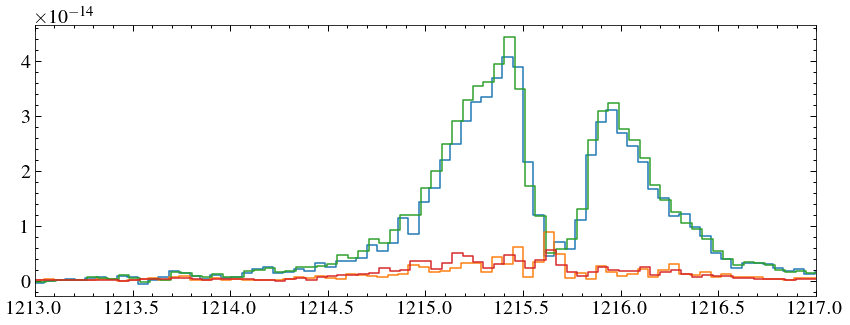

In [6]:
def no_zero_errors(flux, error):
    """
    Corrects instances where negative flux measurements have very small errors
    """
    e_new = error
    for i in range(len(error)):
        if flux[i] < 0.0 and error[i] < 0.1*abs(flux[i]):
            e_new[i] = abs(flux[i])
    return e_new

def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, error

#coadd with just three orbits
sp_to_add = ['coadds/LHS-2686_g140m_odlm34040.ecsv',
 'coadds/LHS-2686_g140m_odlm35030.ecsv',
 'coadds/LHS-2686_g140m_odlm35040.ecsv']

fs = []
es = []
first = True
for x in sp_to_add:
    data = Table.read(x)
    wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
 #   ei = no_zero_errors(fi, ei) 
    if first:
        w_new = wi
        first = False
    else:
        fi = interpolate.interp1d(wi, fi, fill_value='extrapolate')(w_new)
        ei = interpolate.interp1d(wi, ei, fill_value='extrapolate')(w_new)
    fs.append(fi)
    es.append(ei)

f_new, e_new = new_coadd(np.array(fs), np.array(es))
plt.step(w_new, f_new, where='mid')
plt.step(w_new, e_new, where='mid')
#plt.show()
savdat = Table((w_new*u.AA, f_new*u.erg/u.s/u.cm**2/u.AA, e_new*u.erg/u.s/u.cm**2/u.AA), names=['WAVELENGTH', 'FLUX', 'ERROR'])
ascii.write(savdat, 'coadds/LHS-2686_3orbs_g140m_coadd_v1.ecsv', overwrite=True, format='ecsv')

cdata = Table.read(cspec)
w, f, e = cdata['WAVELENGTH'], cdata['FLUX'], cdata['ERROR']
plt.step(w, f, where='mid')
plt.step(w, e, where='mid')

plt.xlim(1213, 1217)

In [7]:
print(specs)
tagfiles = np.hstack((glob.glob('data/*lm34*tag.fits'),glob.glob('data/*lm35*tag.fits')))
tagfiles

['coadds/LHS-2686_g140m_odlm34030.ecsv', 'coadds/LHS-2686_g140m_odlm34040.ecsv', 'coadds/LHS-2686_g140m_odlm35030.ecsv', 'coadds/LHS-2686_g140m_odlm35040.ecsv']


array(['data/odlm34040_tag.fits', 'data/odlm34030_tag.fits',
       'data/odlm35040_tag.fits', 'data/odlm35030_tag.fits'], dtype='<U23')

In [8]:
tstep = 100


In [9]:

for tag in tagfiles:
    hdr = fits.getheader(tag, 1)
    rootname = hdr['ROOTNAME']
    exptime = hdr['EXPTIME']
    nstep = int(exptime/tstep)
    stistools.inttag.inttag(tag, 'lhs2686_subspectra/{0}_{1}s_raw.fits'.format(rootname, tstep), rcount = nstep, increment = tstep)
    
    

imset: 1, start: 0.029500000000000002, stop: 100.0295, exposure time: 100.0
imset: 2, start: 100.0295, stop: 200.02949999999998, exposure time: 99.99999999999999
imset: 3, start: 200.02949999999998, stop: 300.0295, exposure time: 100.0
imset: 4, start: 300.0295, stop: 400.0295, exposure time: 100.0
imset: 5, start: 400.0295, stop: 500.0295, exposure time: 100.0
imset: 6, start: 500.0295, stop: 600.0295, exposure time: 100.0
imset: 7, start: 600.0295, stop: 700.0295, exposure time: 100.0
imset: 8, start: 700.0295, stop: 800.0295, exposure time: 100.0
imset: 9, start: 800.0295, stop: 900.0295, exposure time: 100.0
imset: 10, start: 900.0295, stop: 1000.0295, exposure time: 100.0
imset: 11, start: 1000.0295, stop: 1100.0295, exposure time: 100.00000000000011
imset: 12, start: 1100.0295, stop: 1200.0295, exposure time: 100.0
imset: 13, start: 1200.0295, stop: 1300.0295, exposure time: 100.0
imset: 14, start: 1300.0295, stop: 1400.0295, exposure time: 100.0
imset: 15, start: 1400.0295, stop

In [10]:
oref="${CRDS_PATH}/references/hst/oref/"


In [11]:
splitraw = glob.glob('lhs2686_subspectra/*{}s_raw.fits'.format(tstep))
#print(splitraw)
for raw in splitraw:
    rootname = fits.getheader(raw)['ROOTNAME']
   # a2center = fits.getdata('to_coadd/{}_x1d.fits'.format(rootname), 1)['A2CENTER'][0]
    stistools.x1d.x1d(raw, output = 'lhs2686_subspectra/{0}_{1}s_x1d.fits'.format(rootname, tstep), trailer='lhs2686lcextract.trl')#, a2center=a2center, maxsrch=0)


In [12]:
splitx = glob.glob('lhs2686_subspectra/*{}s_x1d.fits'.format(tstep))
splitx

[]

In [13]:
#hdul=fits.open(splitx[0])
#hdul[2].header
#hdul.close()

<ErrorbarContainer object of 3 artists>

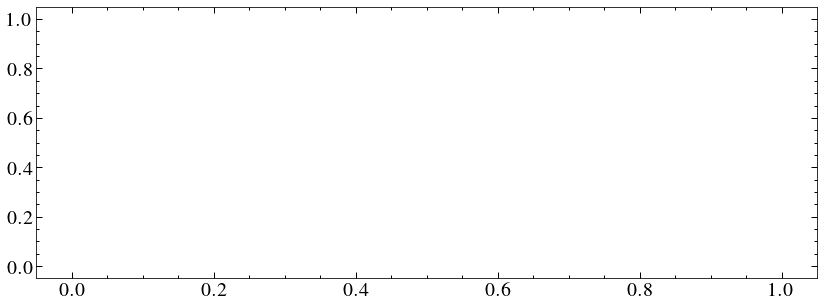

In [14]:
time = []
flux = []
error = []
for x in splitx:
    hdul = fits.open(x)
    for ext in hdul[1:]:
        data = ext.data[0]
        w, f, e, = data['WAVELENGTH'], data['Flux'], data['ERROR']
        mask =  (w > 1214) & (w < 1216) 
        w, f, e = w[mask], f[mask], e[mask]
        ti = ext.header['EXPSTART'] + (ext.header['EXPTIME']/(2*86400))
        fi = np.trapz(f, w)
        #ei = np.trapz(e**2, w)**0.5
        ei = np.sum(e[1:]**2*np.diff(w)**2)**0.5 
        #ei = fi**0.5
        time.append(ti)
        flux.append(fi)
        error.append(ei)
    hdul.close()
time, flux, error = np.array(time), np.array(flux), np.array(error)
args = np.argsort(time)
time, flux, error = time[args], flux[args], error[args]
plt.errorbar(time, flux, yerr=error)

IndexError: index 0 is out of bounds for axis 0 with size 0

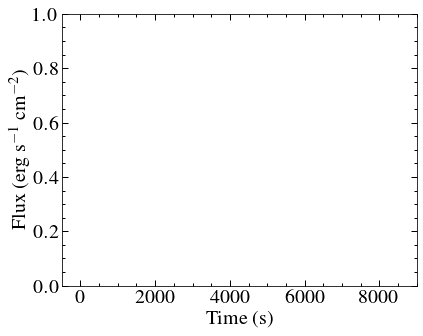

In [15]:
plt.subplot(121)
#plt.errorbar((time-time[0])*86400, flux, marker='o')
#plt.xlim(-0.01, 0.1)
plt.xlim(-500, 9000)
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')
plt.xlabel('Time (s)')
#plt.ylim(-1e-14, 0.1e-12)
plt.errorbar((time-time[0])*86400, flux, yerr=error,ls='none', marker='o') 

plt.subplot(122)
#plt.errorbar((time-time[0])*86400, flux, marker='o')
#plt.xlim(3.75, 3.9 )
plt.xlim(3.25e5, 3.35e5)
plt.xlabel('Time (s)')
plt.errorbar((time-time[0])*86400, flux, yerr=error, ls='none', marker='o')
#plt.ylim(-1e-14, 0.1e-12)
plt.tight_layout()
plt.savefig('LHS-2686_g140m_{}s_lc.png'.format(tstep), dpi=150)

In [ ]:
for x in splitx:
    hdul = fits.open(x)
    for ext in hdul[1:]:
        data = ext.data[0]
        w, f, e, = data['WAVELENGTH'], data['FLUX'], data['ERROR']
        #mask = ((f/e) > 1)
        #w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid')
       # plt.xlim(1214, 1217)

In [ ]:
x1ds= glob.glob('to_coadd/odlm3*')
fits.getdata(x1ds[1],1)['A2CENTER'][0]

In [ ]:
dt = fits.getdata(splitx[0],1)[0]
plt.step(dt['WAVELENGTH'], dt['FLUX'], where='mid')
plt.step(dt['WAVELENGTH'], dt['ERROR'], where='mid')
cdata = Table.read(cspec)
w, f, e = cdata['WAVELENGTH'], cdata['FLUX'], cdata['ERROR']
plt.xlim(1212, 1218)
#plt.step(w, f, where='mid')
#plt.step(w, e, where='mid')

In [ ]:
fits.getdata(splitx[0],1).names

In [ ]:
plt.step(dt['WAVELENGTH'], dt['NET'], where='mid')

In [ ]:
for x in x1ds:
    hdr = fits.getheader(x,1)
    print(hdr['ROOTNAME'], hdr['EXPSTART'])
    

gif time!

In [ ]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(True)

t = (time[:27]-time[0])*86400
ax[0].errorbar(t, flux[:27], yerr=error[:27],ls='none', marker='o') 
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')
ax[0].set_ylim(2.1e-14, 7.9e-14)
line, = ax[0].plot([0,0], [-0.1e-12,1.3e-12], 'C1--', linewidth=2)
ax[1].set_ylim(-0.5e-14, 7e-14)
ax[1].set_xlim(1213, 1217)
ax[1].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax[1].set_xlabel('Wavelength (\AA)')

hdul = fits.open(splitx[0])
rootname = hdul[0].header['ROOTNAME']
print(rootname)
ext = hdul[1::][0]
dt = ext.data[0]
w, f = dt['WAVELENGTH'], dt['FLUX']
smooth = 2
f = convolve(f,Box1DKernel(smooth))
line1, = ax[1].step(w,f, where='mid') 

def update(i):
    #time = t[i]
    line.set_xdata([t[i], t[i]])
    ext = hdul[1::][i]
    dt = ext.data[0]
    w, f = dt['WAVELENGTH'], dt['FLUX']
    f = convolve(f,Box1DKernel(smooth))
    line1.set_xdata(w)
    line1.set_ydata(f)
    return ax, line, line1

anim = FuncAnimation(fig, update, frames=np.arange(len(time)), interval=300)
name = '{0}_{1}s.gif'.format(rootname, tstep)
anim.save(name, dpi=80, writer='imagemagick')
plt.show()

Background flux

In [ ]:
splitraw = glob.glob('lhs2686_subspectra/*{}s_raw.fits'.format(tstep))
for raw in splitraw:
    rootname = fits.getheader(raw)['ROOTNAME']
    a2center = fits.getdata('to_coadd/{}_x1d.fits'.format(rootname), 1)['A2CENTER'][0]
    stistools.x1d.x1d(raw, output = 'lhs_bk_subs/{0}_{1}s_bk2.fits'.format(rootname, tstep), trailer='lhs2686bkextract.trl', a2center=a2center-100, maxsrch=0, backcorr='')

In [ ]:
splitx = glob.glob('lhs_bk_subs/*bk2.fits'.format(tstep))
data = fits.getdata(splitx[0])[0]
plt.plot(data['WAVELENGTH'], data['FLUX'])
plt.xlim(1214, 1216)

In [ ]:

time = []
flux = []
error = []
for x in splitx:
    hdul = fits.open(x)
    for ext in hdul[1:]:
        data = ext.data[0]
        w, f, e, = data['WAVELENGTH'], data['Flux'], data['ERROR']
        mask =  (w > 1214) & (w < 1215) | (w > 1215.5) & (w < 1216) 
        w, f, e = w[mask], f[mask], e[mask]
        ti = ext.header['EXPSTART'] + (ext.header['EXPTIME']/(2*86400))
        fi = np.trapz(f, w)
        #ei = np.trapz(e**2, w)**0.5
        ei = np.sum(e[1:]**2*np.diff(w)**2)**0.5 
        #ei = fi**0.5
        time.append(ti)
        flux.append(fi)
        error.append(ei)
    hdul.close()
time, flux, error = np.array(time), np.array(flux), np.array(error)
args = np.argsort(time)
time, flux, error = time[args], flux[args], error[args]
plt.errorbar(time-time[0], flux, yerr=error)

In [ ]:
plt.figure(figsize=(16,5))
tstarts = [-0.01, 0.06, 3.77, 3.835]
tends = [0.04, 0.099, 3.81, 3.875]
for i in range(len(tstarts)):
    plt.subplot(1,4,i+1)
    plt.errorbar(time-time[0], flux, yerr=error, marker='o', ls='none', label = r'-100')
#    plt.errorbar(time1-time1[0], flux1, yerr=error1, marker='o', ls='none', label = r'+100')
    plt.xlim(tstarts[i], tends[i])
    plt.xlabel('Time (d)')
    if i == 0:
        plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
        plt.legend()

plt.tight_layout()
#plt.savefig('lhs2686_bk.png')


In [ ]:
time1, flux1, error1= time, flux, error